<a href="https://colab.research.google.com/github/Stalinosmj/Malayalam-Transfer-Learning/blob/main/Handwritten_Malayalam_Character_recognition_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malayalam Handwritten characters detection using Transfer Learning

## Import Necessary libraries and models

We will be using MobileNEtV2 due to its lightweight architecture and efficency

In [44]:
# !pip install tensorflow

In [45]:
# !pip install opencv-python
!

In [46]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from PIL import Image
from collections import Counter
import random
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img

In [47]:
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision
set_global_policy('mixed_float16')

## Download and Process dataset

The dataset was provided by  Manjusha K, Malayalam Character Image Database (Amrita_MalCharDb) ,1,ID:Amrita_MalCharDb_1,URL:https://tc11.cvc.uab.es/datasets/Amrita_MalCharDb_1

In [48]:
!gdown 'https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a'
!gdown 'https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00'
!gdown 'https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ'

Downloading...
From: https://drive.google.com/uc?export=download&id=1phWikkOYex57DGxgNv3PgkF0pQ9Nsm1a
To: /content/Handwritten_V2_train.csv
100% 35.3M/35.3M [00:00<00:00, 240MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1ykhOpo8ZjgDfbQ2CdR-zN-X_T8WEtL00
To: /content/Handwritten_V2_valid.csv
100% 11.7M/11.7M [00:00<00:00, 176MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1hzhmO5ZK_aVHUfGeWf3s4bHQPyl5EzUJ
To: /content/Handwritten_V2_test.csv
100% 13.0M/13.0M [00:00<00:00, 127MB/s]


A directory for train_data, test_data, validate_data is made for quick access and random images are plotted

Total number of classes: 85
Class 1: 59 images
Class 2: 102 images
Class 3: 58 images
Class 4: 69 images
Class 5: 62 images
Class 6: 56 images
Class 7: 56 images
Class 8: 64 images
Class 9: 63 images
Class 10: 105 images
Class 11: 67 images
Class 12: 96 images
Class 13: 84 images
Class 14: 109 images
Class 15: 102 images
Class 16: 88 images
Class 17: 101 images
Class 18: 87 images
Class 19: 101 images
Class 20: 77 images
Class 21: 78 images
Class 22: 74 images
Class 23: 75 images
Class 24: 43 images
Class 25: 74 images
Class 26: 76 images
Class 27: 77 images
Class 28: 68 images
Class 29: 69 images
Class 30: 70 images
Class 31: 44 images
Class 32: 71 images
Class 33: 77 images
Class 34: 74 images
Class 35: 70 images
Class 36: 81 images
Class 37: 66 images
Class 38: 73 images
Class 39: 73 images
Class 40: 72 images
Class 41: 74 images
Class 42: 73 images
Class 43: 65 images
Class 44: 79 images
Class 45: 76 images
Class 46: 68 images
Class 47: 43 images
Class 48: 82 images
Class 49: 79 im

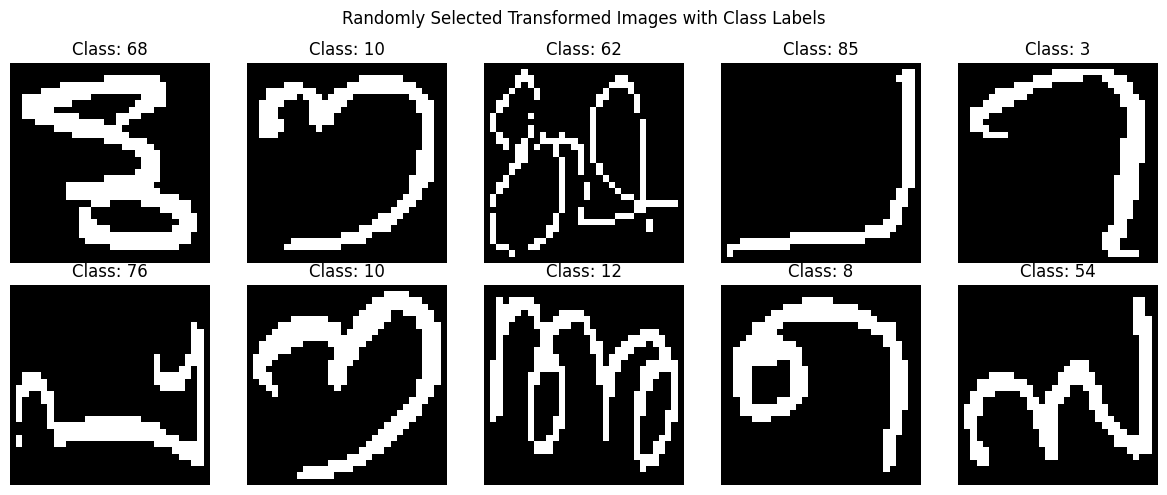

In [49]:
train_data = pd.read_csv("Handwritten_V2_test.csv")
test_data = pd.read_csv("Handwritten_V2_test.csv")
validate_data = pd.read_csv("Handwritten_V2_valid.csv")

# Extract labels and images
train_labels = train_data.iloc[:, 0].values  # First column as labels
train_images = train_data.iloc[:, 1:].values  # Remaining columns as pixel values
train_images = train_images.reshape(-1, 32, 32)  # Reshape to (num_samples, 32, 32)

# Apply transformation (rotate 90° right & mirror)
processed_images = []
for img in train_images:
    img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert array to image
    img_rotated = img_pil.rotate(-90)  # Rotate 90° clockwise
    img_mirrored = img_rotated.transpose(Image.FLIP_LEFT_RIGHT)  # Mirror (flip horizontally)
    processed_images.append(np.array(img_mirrored) / 255.0)  # Normalize again

# Convert list back to NumPy array
train_images = np.array(processed_images)

# Create output directory for sorted images
output_dir = "Train_Images"
os.makedirs(output_dir, exist_ok=True)

# Count images per class
class_counts = Counter(train_labels)

# Print number of unique classes
print(f"Total number of classes: {len(class_counts)}")

# Create subdirectories for each class and print counts
for class_label, count in class_counts.items():
    class_folder = os.path.join(output_dir, str(class_label))
    os.makedirs(class_folder, exist_ok=True)
    print(f"Class {class_label}: {count} images")

# Save processed images into corresponding class folders
for i, (image, label) in enumerate(zip(train_images, train_labels)):
    image_path = os.path.join(output_dir, str(label), f"image_{i}.png")
    img = Image.fromarray((image * 255).astype(np.uint8))  # Convert back to image
    img.save(image_path)

print(f"\nImages successfully saved into class folders inside '{output_dir}'")

# ------ Plot Random Images with Class Labels ------

# Select random indices
random_indices = random.sample(range(len(train_labels)), 10)  # Select 10 random images

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Randomly Selected Transformed Images with Class Labels")

for ax, idx in zip(axes.flat, random_indices):
    image = train_images[idx]  # Get the transformed image
    label = train_labels[idx]  # Get the corresponding label

    ax.imshow(image, cmap='gray')  # Plot image
    ax.set_title(f'Class: {label}')  # Set title
    ax.axis('off')

plt.tight_layout()
plt.show()

Test data images are processed by extracting labels(0) and pixel values, then it is saved back into the folder

Total number of classes: 85
Class 1: 59 images
Class 2: 102 images
Class 3: 58 images
Class 4: 69 images
Class 5: 62 images
Class 6: 56 images
Class 7: 56 images
Class 8: 64 images
Class 9: 63 images
Class 10: 105 images
Class 11: 67 images
Class 12: 96 images
Class 13: 84 images
Class 14: 109 images
Class 15: 102 images
Class 16: 88 images
Class 17: 101 images
Class 18: 87 images
Class 19: 101 images
Class 20: 77 images
Class 21: 78 images
Class 22: 74 images
Class 23: 75 images
Class 24: 43 images
Class 25: 74 images
Class 26: 76 images
Class 27: 77 images
Class 28: 68 images
Class 29: 69 images
Class 30: 70 images
Class 31: 44 images
Class 32: 71 images
Class 33: 77 images
Class 34: 74 images
Class 35: 70 images
Class 36: 81 images
Class 37: 66 images
Class 38: 73 images
Class 39: 73 images
Class 40: 72 images
Class 41: 74 images
Class 42: 73 images
Class 43: 65 images
Class 44: 79 images
Class 45: 76 images
Class 46: 68 images
Class 47: 43 images
Class 48: 82 images
Class 49: 79 im

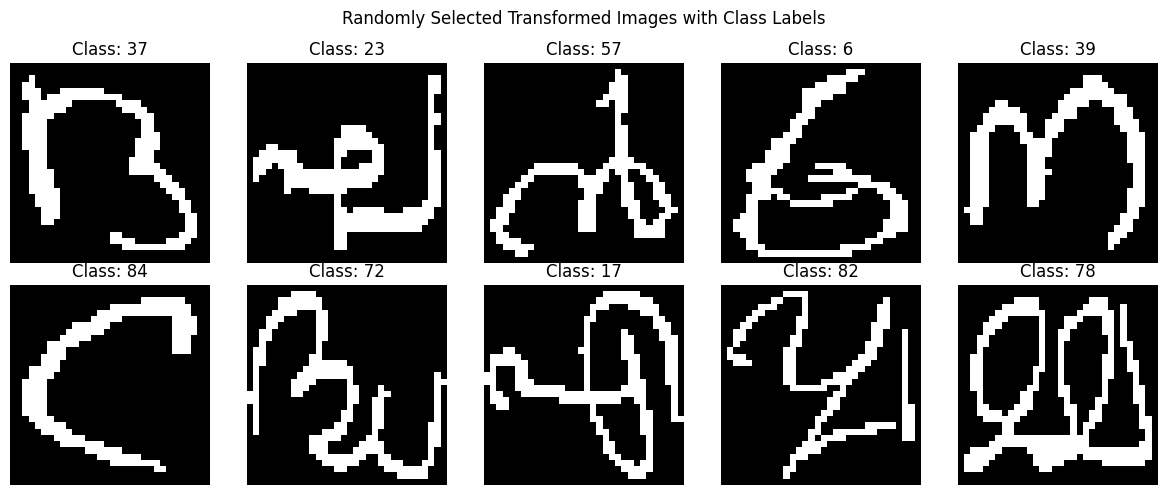

In [50]:
# Extract labels and images
test_labels = test_data.iloc[:, 0].values  # First column as labels
test_images = test_data.iloc[:, 1:].values  # Remaining columns as pixel values
test_images = test_images.reshape(-1, 32, 32)  # Reshape to (num_samples, 32, 32)

# Apply transformation (rotate 90° right & mirror)
processed_images = []
for img in test_images:
    img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert array to image
    img_rotated = img_pil.rotate(-90)  # Rotate 90° clockwise
    img_mirrored = img_rotated.transpose(Image.FLIP_LEFT_RIGHT)  # Mirror (flip horizontally)
    processed_images.append(np.array(img_mirrored) / 255.0)  # Normalize again

# Convert list back to NumPy array
test_images = np.array(processed_images)

# Create output directory for sorted images
output_dir = "Test_Images"
os.makedirs(output_dir, exist_ok=True)

# Count images per class
class_counts = Counter(test_labels)

# Print number of unique classes
print(f"Total number of classes: {len(class_counts)}")

# Create subdirectories for each class and print counts
for class_label, count in class_counts.items():
    class_folder = os.path.join(output_dir, str(class_label))
    os.makedirs(class_folder, exist_ok=True)
    print(f"Class {class_label}: {count} images")

# Save processed images into corresponding class folders
for i, (image, label) in enumerate(zip(test_images, test_labels)):
    image_path = os.path.join(output_dir, str(label), f"image_{i}.png")
    img = Image.fromarray((image * 255).astype(np.uint8))  # Convert back to image
    img.save(image_path)

print(f"\nImages successfully saved into class folders inside '{output_dir}'")

# ------ Plot Random Images with Class Labels ------

# Select random indices
random_indices = random.sample(range(len(test_labels)), 10)  # Select 10 random images

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Randomly Selected Transformed Images with Class Labels")

for ax, idx in zip(axes.flat, random_indices):
    image = test_images[idx]  # Get the transformed image
    label = test_labels[idx]  # Get the corresponding label

    ax.imshow(image, cmap='gray')  # Plot image
    ax.set_title(f'Class: {label}')  # Set title
    ax.axis('off')

plt.tight_layout()
plt.show()

Validate image data is processed by extracting its labels(0) and pixel values, It is then saved back into the folder

Total number of classes: 85
Class 1: 59 images
Class 2: 105 images
Class 3: 63 images
Class 4: 63 images
Class 5: 59 images
Class 6: 61 images
Class 7: 58 images
Class 8: 64 images
Class 9: 68 images
Class 10: 76 images
Class 11: 57 images
Class 12: 76 images
Class 13: 63 images
Class 14: 75 images
Class 15: 77 images
Class 16: 65 images
Class 17: 73 images
Class 18: 65 images
Class 19: 83 images
Class 20: 70 images
Class 21: 67 images
Class 22: 70 images
Class 23: 67 images
Class 24: 61 images
Class 25: 66 images
Class 26: 63 images
Class 27: 68 images
Class 28: 60 images
Class 29: 66 images
Class 30: 69 images
Class 31: 63 images
Class 32: 61 images
Class 33: 65 images
Class 34: 70 images
Class 35: 70 images
Class 36: 71 images
Class 37: 69 images
Class 38: 65 images
Class 39: 66 images
Class 40: 58 images
Class 41: 69 images
Class 42: 68 images
Class 43: 65 images
Class 44: 72 images
Class 45: 68 images
Class 46: 66 images
Class 47: 60 images
Class 48: 70 images
Class 49: 67 images


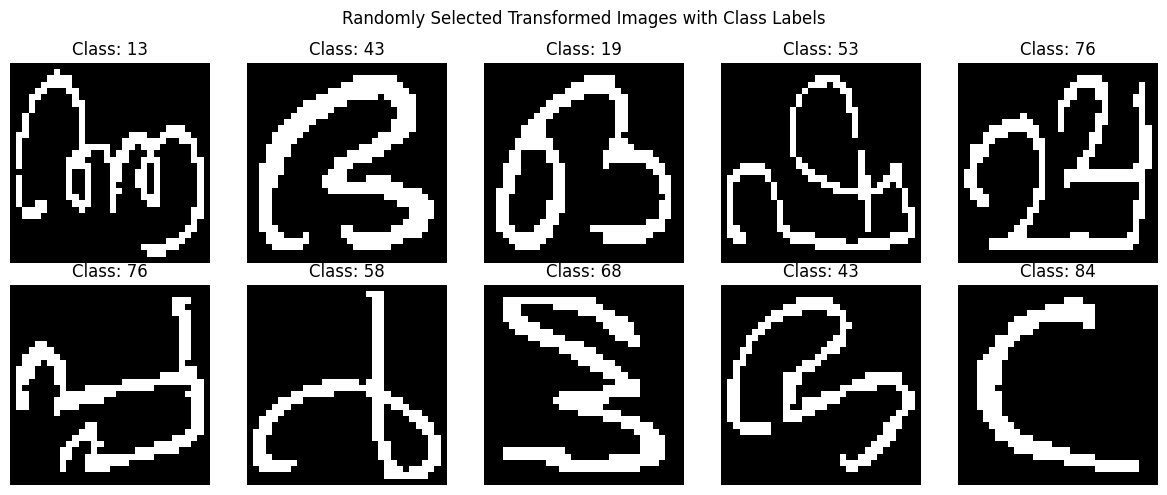

In [51]:
# Extract labels and images
validate_labels = validate_data.iloc[:, 0].values  # First column as labels
validate_images = validate_data.iloc[:, 1:].values  # Remaining columns as pixel values
validate_images = validate_images.reshape(-1, 32, 32)  # Reshape to (num_samples, 32, 32)

# Apply transformation (rotate 90° right & mirror)
processed_images = []
for img in validate_images:
    img_pil = Image.fromarray((img * 255).astype(np.uint8))  # Convert array to image
    img_rotated = img_pil.rotate(-90)  # Rotate 90° clockwise
    img_mirrored = img_rotated.transpose(Image.FLIP_LEFT_RIGHT)  # Mirror (flip horizontally)
    processed_images.append(np.array(img_mirrored) / 255.0)  # Normalize again

# Convert list back to NumPy array
validate_images = np.array(processed_images)

# Create output directory for sorted images
output_dir = "Validate_Images"
os.makedirs(output_dir, exist_ok=True)

# Count images per class
class_counts = Counter(validate_labels)

# Print number of unique classes
print(f"Total number of classes: {len(class_counts)}")

# Create subdirectories for each class and print counts
for class_label, count in class_counts.items():
    class_folder = os.path.join(output_dir, str(class_label))
    os.makedirs(class_folder, exist_ok=True)
    print(f"Class {class_label}: {count} images")

# Save processed images into corresponding class folders
for i, (image, label) in enumerate(zip(validate_images, validate_labels)):
    image_path = os.path.join(output_dir, str(label), f"image_{i}.png")
    img = Image.fromarray((image * 255).astype(np.uint8))  # Convert back to image
    img.save(image_path)

print(f"\nImages successfully saved into class folders inside '{output_dir}'")

# ------ Plot Random Images with Class Labels ------

# Select random indices
random_indices = random.sample(range(len(validate_labels)), 10)  # Select 10 random images

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Randomly Selected Transformed Images with Class Labels")

for ax, idx in zip(axes.flat, random_indices):
    image = validate_images[idx]  # Get the transformed image
    label = validate_labels[idx]  # Get the corresponding label

    ax.imshow(image, cmap='gray')  # Plot image
    ax.set_title(f'Class: {label}')  # Set title
    ax.axis('off')

plt.tight_layout()
plt.show()

Data augmentation is performed for removing overfitting

Class '45': 500 images before augmentation.
Class '29': 500 images before augmentation.
Class '83': 500 images before augmentation.
Class '74': 500 images before augmentation.
Class '54': 500 images before augmentation.
Class '63': 500 images before augmentation.
Class '57': 500 images before augmentation.
Class '17': 500 images before augmentation.
Class '78': 500 images before augmentation.
Class '39': 500 images before augmentation.
Class '52': 500 images before augmentation.
Class '24': 500 images before augmentation.
Class '66': 500 images before augmentation.
Class '73': 500 images before augmentation.
Class '76': 500 images before augmentation.
Class '33': 500 images before augmentation.
Class '7': 500 images before augmentation.
Class '70': 500 images before augmentation.
Class '22': 500 images before augmentation.
Class '11': 500 images before augmentation.
Class '19': 500 images before augmentation.
Class '60': 500 images before augmentation.
Class '48': 500 images before aug

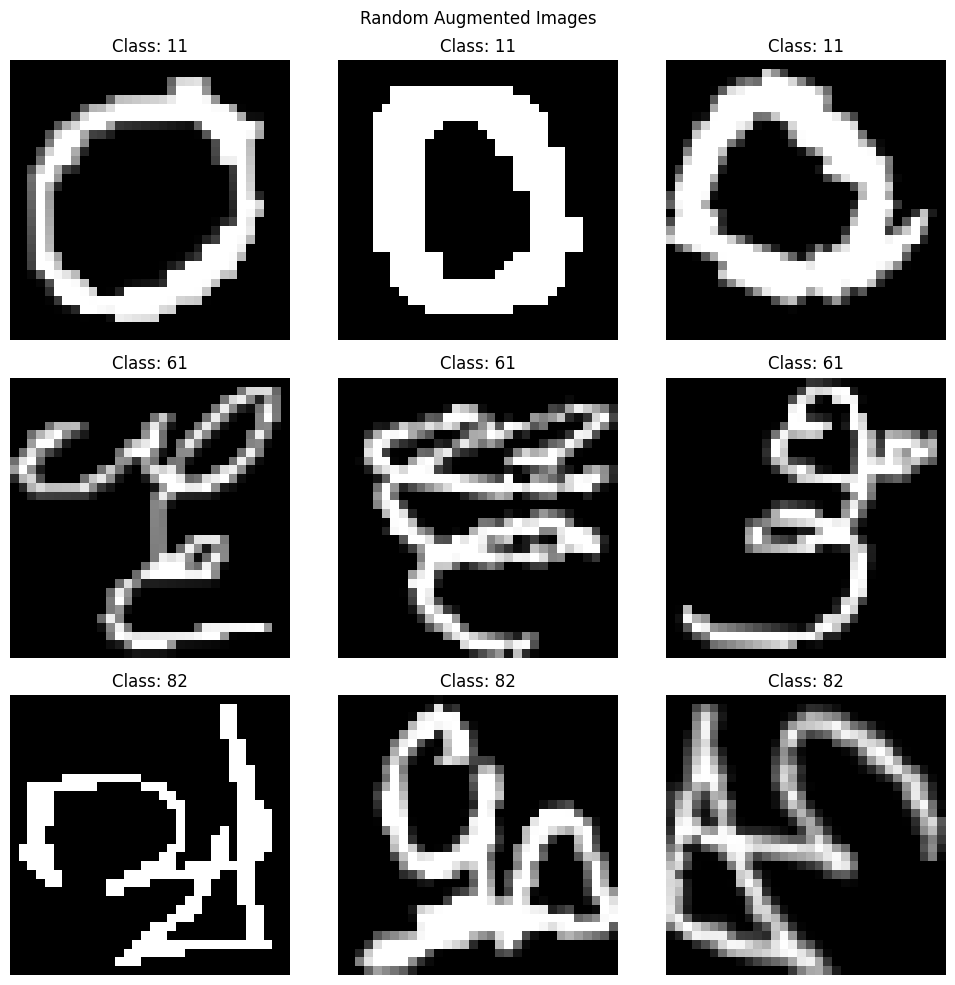

In [52]:
# Define paths
train_dir = "Train_Images"  # Root directory containing class subfolders
target_images_per_class = 500  # Ensure each class has at least 500 images

# Define ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate by ±20 degrees
    width_shift_range=0.02,   # Shift width by 2%
    height_shift_range=0.02,  # Shift height by 2%
    shear_range=0.15,        # Shear transformation
    zoom_range=0.02,          # Zoom in/out by 2%
    horizontal_flip=True,    # Flip horizontally
    fill_mode="nearest"      # Fill empty areas
)

# Function to rotate and mirror an image
def preprocess_image(image):
    # Rotate 90 degrees to the right
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    # Mirror the image
    image = cv2.flip(image, 1)  # Flip horizontally
    return image

# Store class counts before augmentation
class_counts = {}

# Loop through each class folder
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip if not a directory

    # Get list of image files in the class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith((".jpg", ".png", ".jpeg"))]
    num_images = len(image_files)
    class_counts[class_name] = num_images

    print(f"Class '{class_name}': {num_images} images before augmentation.")

    # Augment images if class has less than 500 images
    if num_images < target_images_per_class:
        required_images = target_images_per_class - num_images  # Number of new images needed
        images_to_augment = random.choices(image_files, k=required_images)  # Random selection

        for img_name in images_to_augment:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)  # Load image
            img = img_to_array(img)   # Convert to NumPy array

            # Apply initial rotation & mirroring
            img = preprocess_image(img)

            img = img.reshape((1,) + img.shape)  # Reshape for ImageDataGenerator

            # Generate augmented images
            i = 0
            for batch in datagen.flow(img, batch_size=1, save_to_dir=class_path, save_format="png"):
                i += 1
                if i >= 1:  # Generate 1 image per original image (adjustable)
                    break

# Print final class counts after augmentation
print("\nFinal class counts after augmentation:")
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith((".jpg", ".png", ".jpeg", ".png"))])
        print(f"Class '{class_name}': {num_images} images")

# Plot some random augmented images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Random Augmented Images")

random_classes = random.sample(os.listdir(train_dir), min(3, len(os.listdir(train_dir))))  # Pick 3 random classes
for i, class_name in enumerate(random_classes):
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith((".jpg", ".png", ".jpeg"))]
    random_images = random.sample(image_files, min(3, len(image_files)))  # Pick 3 random images

    for j, img_name in enumerate(random_images):
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"Class: {class_name}")
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

In [53]:
# Define directories
train_dir = "Train_Images"
test_dir = "Test_Images"
val_dir = "Validate_Images"

# Define image size & batch size
IMG_SIZE = (224, 224)  # Resize to 224x224 for MobileNetV2
BATCH_SIZE = 64

In [54]:
# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,   # Normalize pixel values (0-1)
    rotation_range=20,    # Rotate by ±20 degrees
    width_shift_range=0.2, # Horizontal shift
    height_shift_range=0.2, # Vertical shift
    shear_range=0.2,      # Shear transformation
    zoom_range=0.2,       # Zoom
    horizontal_flip=True, # Flip horizontally
    fill_mode="nearest"   # Fill missing pixels
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"  # Multi-class classification
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Get number of classes
num_classes = len(train_generator.class_indices)

Found 42500 images belonging to 85 classes.
Found 5705 images belonging to 85 classes.
Found 6359 images belonging to 85 classes.


## Load base model : MobileNetV2 and freeze trainning

In [55]:
# Load MobileNetV2 (pre-trained on ImageNet)
base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Build custom model specific to our task

In [56]:
# Build custom model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten with GAP
x = Dense(512, activation="relu")(x)  # Fully Connected Layer
x = BatchNormalization()(x)  # Batch Normalization
x = Dropout(0.4)(x)  # Dropout to prevent overfitting
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation="softmax")(x)  # Output layer

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [58]:
from google.colab import files

checkpoint = ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    verbose=1
)

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers
    layer.trainable = True

In [59]:
# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)       

 Total params: 1,390,789 (5.31 MB)

 Trainable params: 800,869 (3.06 MB)

 Non-trainable params: 589,920 (2.25 MB)

## Train the custom model
this step might actually take approx 6hrs

In [ ]:
# Train model
EPOCHS = 64  # Adjust as needed
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, early_stop, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/64
 62/665 ━━━━━━━━━━━━━━━━━━━━ 7:12 717ms/step - accuracy: 0.0168 - loss: 5.3821

## Evaluate the performance of custom model

In [ ]:
# Plot Accuracy & Loss Curves
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_training_history(history)


## Unfreeze MobileNetV2 and allow it to transfer learn on custom model

In [ ]:
EPOCHS = 10
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(
    train_generator,
    validation_data=val_generator,
    batch_size = 32,
    epochs=EPOCHS
)

## Evaluate the combined accuracy and loss

In [ ]:
# Plot Accuracy & Loss Curves
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Best Model Test Accuracy: {test_acc:.4f}")

## Save the model for future use
(plan to build an app 😀)

In [ ]:
model.save("best_model.h5")

## Use earlystopping to finetune the model and provide maximum accuracy

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# for layer in base_model.layers[:100]:
#     layer.trainable = False  # Keep first 100 layers frozen

# # Compile the model with a lower learning rate
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#               loss="categorical_crossentropy",
#               metrics=["accuracy"])

# # Set up callbacks
# callbacks = [
#     ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1),
#     EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1)
# ]

# # Train the model
# history_finetune = model.fit(
#     train_generator,
#     validation_data=val_generator,
#     batch_size=32,
#     epochs=10,  # Increased epochs for fine-tuning
#     callbacks=callbacks
# )

In [ ]:
# Load the best model
from tensorflow.keras.models import load_model
best_model = load_model("best_model.keras")

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Best Model Test Accuracy: {test_acc:.4f}")